# 3.4 Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_text, DecisionTreeClassifier

np.random.seed(42)

In [2]:
df = pd.read_csv('./cleaned_data')
# dropping new rows with null selftext values
df.drop(df.loc[df['selftext'].isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

X = df['selftext']
y = df['solotravel']

tvec = TfidfVectorizer()
tvec.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_train_transformed = tvec.transform(X_train)
X_test_transformed = tvec.transform(X_test)

In [3]:
def scores(model):
    print(f'train score: {model.score(X_train_transformed, y_train)}')
    print(f'test score: {model.score(X_test_transformed, y_test)}')
    print()
    try:
        print(f'best score: {model.best_score_}')
        print(f'best params: {model.best_params_}')
    except:
        pass

### Our models seem to be suffering from high bias/underfitting so we should boost to combat that

### How well does a decision tree perform?

In [4]:
dtc = DecisionTreeClassifier(max_depth=10)

In [5]:
dtc.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=10)

In [6]:
print(dtc.score(X_train_transformed, y_train))
print(dtc.score(X_test_transformed, y_test))

0.7331207801950488
0.7250562640660165


Pretty consistent results with what we've had so far.

## AdaBoostClassifier

In [7]:
abc = AdaBoostClassifier(random_state=42)

In [8]:
%%time
abc.fit(X_train_transformed, y_train)

CPU times: user 42.5 s, sys: 603 ms, total: 43.1 s
Wall time: 43.2 s


AdaBoostClassifier(random_state=42)

In [9]:
print(abc.score(X_train_transformed, y_train))
print(abc.score(X_test_transformed, y_test))

0.7416229057264316
0.7396849212303076


In [10]:
abc_params = {
    'n_estimators': [25, 75, 150], 
    'learning_rate': [0.01, 0.1, 0.5]   
}

In [11]:
%%time
gs = GridSearchCV(abc, abc_params, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: user 2min 7s, sys: 2.09 s, total: 2min 10s
Wall time: 21min 37s


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [25, 75, 150]},
             verbose=1)

In [12]:
scores(gs)

train score: 0.7572205551387847
test score: 0.748062015503876

best score: 0.7492808323588777
best params: {'learning_rate': 0.5, 'n_estimators': 150}


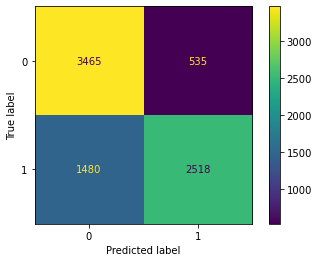

In [13]:
cm = confusion_matrix(y_test, gs.predict(X_test_transformed))
ConfusionMatrixDisplay(cm).plot();

The training and testing scores here are roughly equivalent to that of the NB and SVM models.